In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [2]:
!pip install tensorflow-gpu==2.0.0-rc1

     |████████████████████████████████| 380.5MB 46kB/s 
     |████████████████████████████████| 501kB 51.4MB/s 
     |████████████████████████████████| 4.3MB 54.2MB/s 


In [0]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import random

In [0]:
def noisy(noise_typ,image):
  if noise_typ == "addpixel":
    add_1 = np.where(image < (255/255.0), image+(1/255.0), image)
    add_5 = np.where(image < (250/255.0), image+(5/255.0), image)
    return add_1, add_5

  elif noise_typ == "line_1":
    stride = np.full((image.shape[0], image.shape[1], image.shape[2]), 1.0)
    k = -(image.shape[0]-1)
    while -image.shape[0] < k < image.shape[0]:
      for x in range(image.shape[1]):
        y = x+k
        if 0< y < 224:
          stride[y][x][:] = 0
      k+=20
    stride_image = image * stride
    return stride_image

  elif noise_typ == "line_2":
    stride = np.full((image.shape[0], image.shape[1], image.shape[2]), 1.0)
    k = -(image.shape[0]-1)
    while -image.shape[0] < k < image.shape[0]:
      for x in range(image.shape[1]):
        y = x+k
        if 0< y < 224:
          stride[y][x][:] = 0
      k+=20
    stride_image_1 = (0.9*image) + (0.1*stride)
    stride_image_2 = (0.95*image) + (0.05*stride)
    return stride_image_1, stride_image_2
    
  elif noise_typ == "random":
    ch_ratio = np.array([0.1, 0.3, 0.5])
    out_10 = np.copy(image)
    out_30 = np.copy(image)
    out_50 = np.copy(image)

    num_rand = np.ceil(ch_ratio * image.size)

    coords_10 = [np.random.randint(0, i - 1, int(num_rand[0])) for i in image.shape]
    coords_30 = [np.random.randint(0, i - 1, int(num_rand[1])) for i in image.shape]
    coords_50 = [np.random.randint(0, i - 1, int(num_rand[2])) for i in image.shape]

    for i in zip(coords_10[0], coords_10[1], coords_10[2]):
      out_10[i] = out_10[i] + random.uniform((-5/255.0),(5/255.0))
    for j in zip(coords_30[0], coords_30[1], coords_30[2]):
      out_30[j] = out_30[j] + random.uniform((-5/255.0),(5/255.0))
    for k in zip(coords_50[0], coords_50[1], coords_50[2]):
      out_50[k] = out_50[k] + random.uniform((-5/255.0),(5/255.0))

    return out_10, out_30, out_50

  elif noise_typ == "gauss":
    row,col,ch= image.shape
    mean = 0
    var = 0.1
    sigma = var**2.0
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss
    return noisy

  elif noise_typ == "s&p":
    s_vs_p = 0.5
    amount = 0.004
    out = np.copy(image)
    # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    out[coords] = 1

    # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    out[coords] = 0
    return out

  elif noise_typ == "poisson":
    vals = len(np.unique(image))
    vals = 2 ** np.ceil(np.log2(vals))
    noisy = np.random.poisson(image * vals) / float(vals)
    return noisy

  elif noise_typ =="speckle":
    row,col,ch = image.shape
    gauss = np.random.randn(row,col,ch)
    gauss = gauss.reshape(row,col,ch)        
    noisy = image + image * gauss * 0.2
    return noisy

In [0]:
def grad_cam(model, img_list):
  plt.figure(figsize=(20, 20))
  for i in range(len(img_list)):
    cp_img = img_list[i].copy()
    cp_img*=255.0
    cp_img = cp_img.astype(np.uint8)
    x = img_list[i].copy()
    #x.astype(np.float32)
    x = np.expand_dims(x, axis=0)
    #x = x / 255.0
    
    grad_model = tf.keras.models.Model(
          [model.inputs], [model.get_layer('conv2d_12').output, model.output]
      )
      
    with tf.GradientTape() as tape:
        inputs = tf.cast(x, tf.float32)
        model_outputs, predictions = grad_model(inputs)
        loss = predictions[:,0]

    grads = tape.gradient(loss, model_outputs)

    guided_grads = (
          tf.cast(model_outputs > 0, "float32") * tf.cast(grads > 0, "float32") * grads
    )

    prediction = predictions[0]
    model_outputs = model_outputs[0]
    plt.subplot(4, 5, i+1)
    weights = np.mean(grads, axis=(1, 2))
    weights = weights.reshape(512, 1)

    cam = (prediction -0.5) * np.matmul(model_outputs, weights)
    cam -= np.min(cam)
    cam /= np.max(cam)
    cam -= 0.2
    cam /= 0.8

    try:
      cam = cv2.resize(np.float32(cam), (img_list[i].shape[0], img_list[i].shape[1]))
    except Exception as e:
      #print(cam.shape)
      print(str(e))

    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    heatmap[np.where(cam <= 0.2)] = 0
    grad_cam = cv2.addWeighted(cp_img, 0.8, heatmap, 0.4, 0)
    #plt.axis('off')
    plt.title('grad_cam')
    plt.imshow(grad_cam[:, :, ::-1])

In [0]:
dog = cv2.imread("/content/gdrive/My Drive/dataset/cat_vs_dog/convert/dog.2.jpg")
dog = cv2.cvtColor(dog, cv2.COLOR_BGR2RGB)
dog = cv2.resize(dog, (224,224))
dog = dog/255.0

cat = cv2.imread("/content/gdrive/My Drive/dataset/cat_vs_dog/convert/cat.21.jpg")
cat = cv2.cvtColor(cat, cv2.COLOR_BGR2RGB)
cat = cv2.resize(cat, (224,224))
cat = cat/255.0

apple = cv2.imread("/content/gdrive/My Drive/dataset/cat_vs_dog/convert/apple.jpeg")
apple = cv2.cvtColor(apple, cv2.COLOR_BGR2RGB)
apple = cv2.resize(apple, (224,224))
apple = apple/255.0

galaxy = cv2.imread("/content/gdrive/My Drive/dataset/cat_vs_dog/convert/galaxy.jpeg")
galaxy = cv2.cvtColor(galaxy, cv2.COLOR_BGR2RGB)
galaxy = cv2.resize(galaxy, (224,224))
galaxy = galaxy/255.0

In [7]:
dog_add_1, dog_add_5 = noisy("addpixel", dog)
dog_random_10, dog_random_30, dog_random_50 = noisy("random", dog)
dog_add_line_1 = noisy("line_1", dog)
dog_add_line_2, dog_add_line_3 = noisy("line_2", dog)
dog_add_gauss = noisy("gauss", dog)
dog_add_sp = noisy("s&p", dog)
dog_add_poisson = noisy("poisson", dog)
dog_add_speckle = noisy("speckle", dog)

cat_add_1, cat_add_5 = noisy("addpixel", cat)
cat_random_10, cat_random_30, cat_random_50 = noisy("random", cat)
cat_add_line_1 = noisy("line_1", cat)
cat_add_line_2, cat_add_line_3 = noisy("line_2", cat)
cat_add_gauss = noisy("gauss", cat)
cat_add_sp = noisy("s&p", cat)
cat_add_poisson = noisy("poisson", cat)
cat_add_speckle = noisy("speckle", cat)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:75: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [8]:
vgg_trained_model = tf.keras.models.load_model('/content/gdrive/My Drive/vgg16_epoch250.h5')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [9]:
vgg_trained_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584

# 개


In [0]:
dog_pred = vgg_trained_model(np.expand_dims(dog,axis=0))

dog_add_1_pred = vgg_trained_model(np.expand_dims(dog_add_1,axis=0))
dog_add_5_pred = vgg_trained_model(np.expand_dims(dog_add_5,axis=0))

dog_add_random_10_pred = vgg_trained_model(np.expand_dims(dog_random_10,axis=0))
dog_add_random_30_pred = vgg_trained_model(np.expand_dims(dog_random_30,axis=0))
dog_add_random_50_pred = vgg_trained_model(np.expand_dims(dog_random_50,axis=0))

dog_add_line_1_pred = vgg_trained_model(np.expand_dims(dog_add_line_1,axis=0))
dog_add_line_2_pred = vgg_trained_model(np.expand_dims(dog_add_line_2,axis=0))
dog_add_line_3_pred = vgg_trained_model(np.expand_dims(dog_add_line_3,axis=0))

dog_add_gauss_pred = vgg_trained_model(np.expand_dims(dog_add_gauss,axis=0))

dog_add_sp_pred = vgg_trained_model(np.expand_dims(dog_add_sp,axis=0))

dog_add_poisson_pred = vgg_trained_model(np.expand_dims(dog_add_poisson,axis=0))

dog_add_speckle_pred = vgg_trained_model(np.expand_dims(dog_add_speckle,axis=0))

apple_pred = vgg_trained_model(np.expand_dims(apple,axis=0))
galaxy_pred = vgg_trained_model(np.expand_dims(galaxy,axis=0))

## 픽셀값 1, 5 증가 사진 비교

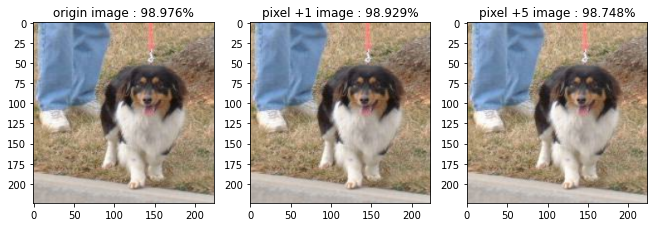

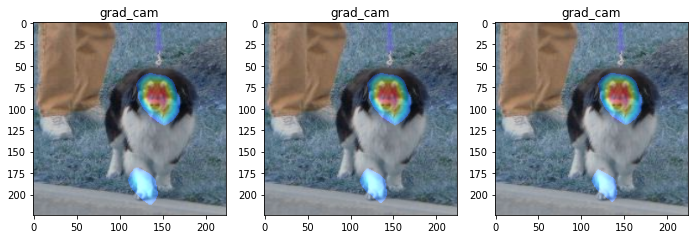

In [11]:
plt.figure(figsize=(11,11))
plt.subplot(1,3,1)
plt.title("origin image : {}%".format(round(float(dog_pred[0][0]*100),3)))
plt.imshow(dog[:,:,:])

plt.subplot(1,3,2)
plt.title("pixel +1 image : {}%".format(round(float(dog_add_1_pred[0][0]*100),3)))
plt.imshow(dog_add_1[:,:,:])

plt.subplot(1,3,3)
plt.title("pixel +5 image : {}%".format(round(float(dog_add_5_pred[0][0]*100),3)))
plt.imshow(dog_add_5[:,:,:])

grad_cam(vgg_trained_model, [dog,dog_add_1, dog_add_5])

## 이미지 랜덤 피셀값 증가, 감소 
* 전체 픽셀 10, 30, 50% 각 픽셀값 -5 ~ +5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


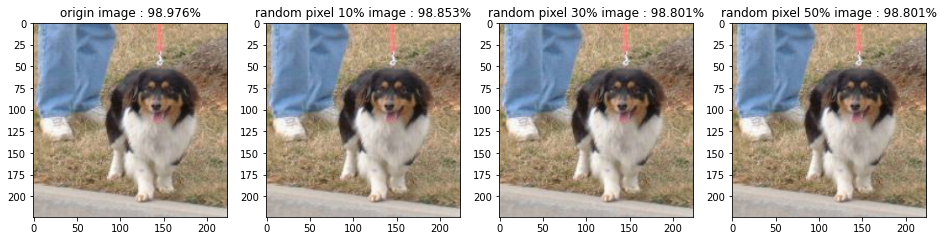

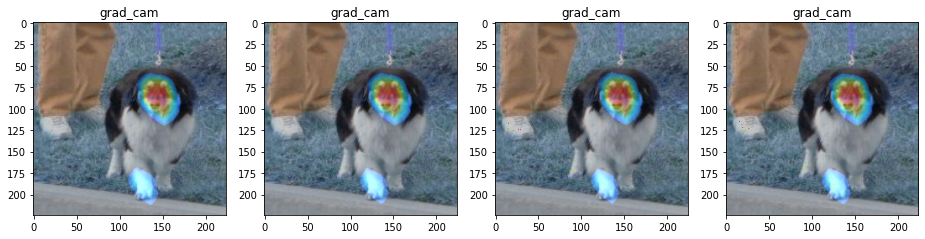

In [12]:
plt.figure(figsize=(16,16))
plt.subplot(1,4,1)
plt.title("origin image : {}%".format(round(float(dog_pred[0][0]*100),3)))
plt.imshow(dog[:,:,:])

plt.subplot(1,4,2)
plt.title("random pixel 10% image : {}%".format(round(float(dog_add_random_10_pred[0][0]*100),3)))
plt.imshow(dog_random_10[:,:,:])

plt.subplot(1,4,3)
plt.title("random pixel 30% image : {}%".format(round(float(dog_add_random_30_pred[0][0]*100),3)))
plt.imshow(dog_random_30[:,:,:])

plt.subplot(1,4,4)
plt.title("random pixel 50% image : {}%".format(round(float(dog_add_random_50_pred[0][0]*100),3)))
plt.imshow(dog_random_50[:,:,:])

grad_cam(vgg_trained_model, [dog, dog_random_10, dog_random_30, dog_random_50])

## 사선 이미지 합성 사진 비교

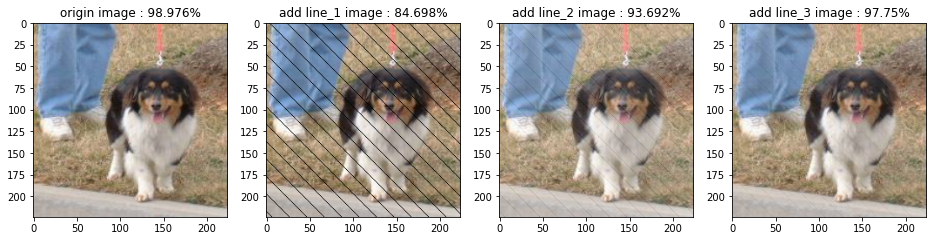

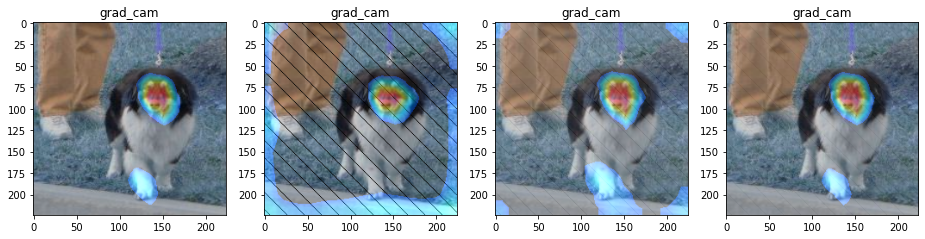

In [13]:
plt.figure(figsize=(16,16))
plt.subplot(1,4,1)
plt.title("origin image : {}%".format(round(float(dog_pred[0][0]*100),3)))
plt.imshow(dog[:,:,:])

plt.subplot(1,4,2)
plt.title("add line_1 image : {}%".format(round(float(dog_add_line_1_pred[0][0]*100),3)))
plt.imshow(dog_add_line_1[:,:,:])

plt.subplot(1,4,3)
plt.title("add line_2 image : {}%".format(round(float(dog_add_line_2_pred[0][0]*100),3)))
plt.imshow(dog_add_line_2[:,:,:])

plt.subplot(1,4,4)
plt.title("add line_3 image : {}%".format(round(float(dog_add_line_3_pred[0][0]*100),3)))
plt.imshow(dog_add_line_3[:,:,:])

grad_cam(vgg_trained_model, [dog, dog_add_line_1, dog_add_line_2, dog_add_line_3])

## 가우시안 노이즈 사진 비교

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


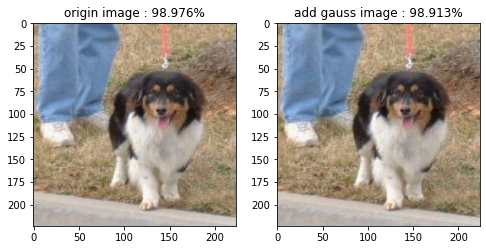

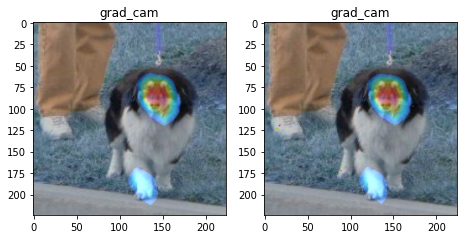

In [14]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.title("origin image : {}%".format(round(float(dog_pred[0][0]*100),3)))
plt.imshow(dog[:,:,:])

plt.subplot(1,2,2)
plt.title("add gauss image : {}%".format(round(float(dog_add_gauss_pred[0][0]*100),3)))
plt.imshow(dog_add_gauss[:,:,:])

grad_cam(vgg_trained_model, [dog, dog_add_gauss])

## 소금 후추 노이즈 사진 비교

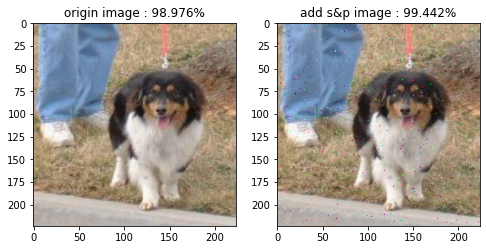

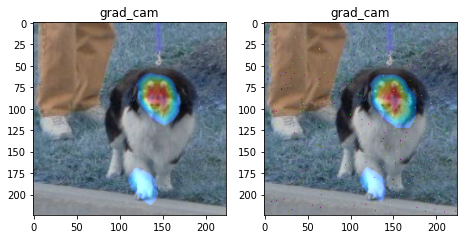

In [15]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.title("origin image : {}%".format(round(float(dog_pred[0][0]*100),3)))
plt.imshow(dog[:,:,:])

plt.subplot(1,2,2)
plt.title("add s&p image : {}%".format(round(float(dog_add_sp_pred[0][0]*100),3)))
plt.imshow(dog_add_sp[:,:,:])

grad_cam(vgg_trained_model, [dog, dog_add_sp])

## 푸아송 노이즈 사진 비교

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


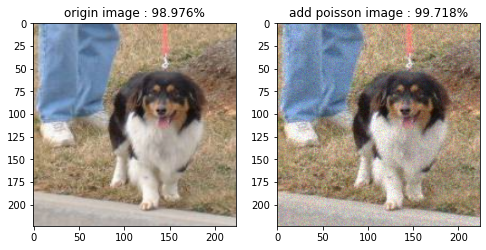

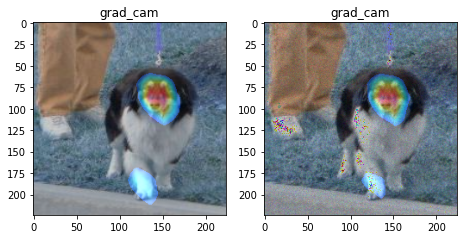

In [16]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.title("origin image : {}%".format(round(float(dog_pred[0][0]*100),3)))
plt.imshow(dog[:,:,:])

plt.subplot(1,2,2)
plt.title("add poisson image : {}%".format(round(float(dog_add_poisson_pred[0][0]*100),3)))
plt.imshow(dog_add_poisson[:,:,:])

grad_cam(vgg_trained_model, [dog, dog_add_poisson])

## 스펙클 노이즈 사진 비교

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


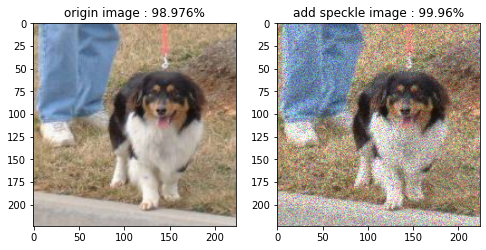

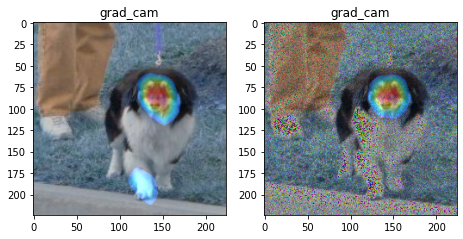

In [17]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.title("origin image : {}%".format(round(float(dog_pred[0][0]*100),3)))
plt.imshow(dog[:,:,:])

plt.subplot(1,2,2)
plt.title("add speckle image : {}%".format(round(float(dog_add_speckle_pred[0][0]*100),3)))
plt.imshow(dog_add_speckle[:,:,:])

grad_cam(vgg_trained_model, [dog, dog_add_speckle])

# 다른 이미지 포멧 형식에서의 비교

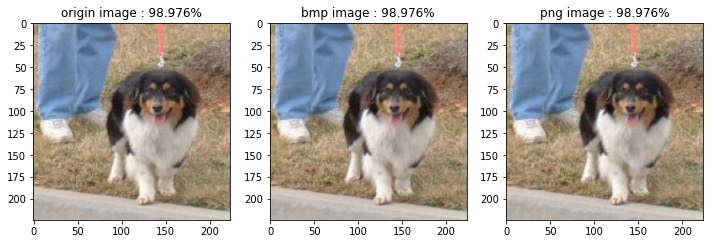

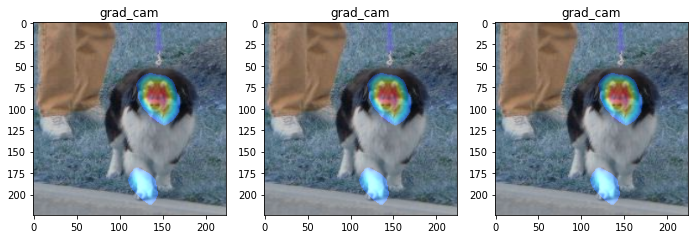

In [18]:
dog_bmp = cv2.imread("/content/gdrive/My Drive/dataset/cat_vs_dog/convert/dog.2.bmp")
dog_bmp = cv2.cvtColor(dog_bmp, cv2.COLOR_BGR2RGB)
dog_bmp = cv2.resize(dog_bmp, (224,224))
dog_bmp = dog_bmp/255.0

dog_png = cv2.imread("/content/gdrive/My Drive/dataset/cat_vs_dog/convert/dog.2.png")
dog_png = cv2.cvtColor(dog_png, cv2.COLOR_BGR2RGB)
dog_png = cv2.resize(dog_png, (224,224))
dog_png = dog_png/255.0

dog_bmp_pred = vgg_trained_model(np.expand_dims(dog_bmp,axis=0))
dog_png_pred = vgg_trained_model(np.expand_dims(dog_png,axis=0))

plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
plt.title("origin image : {}%".format(round(float(dog_pred[0][0]*100),3)))
plt.imshow(dog[:,:,:])

plt.subplot(1,3,2)
plt.title("bmp image : {}%".format(round(float(dog_bmp_pred[0][0]*100),3)))
plt.imshow(dog_bmp[:,:,:])

plt.subplot(1,3,3)
plt.title("png image : {}%".format(round(float(dog_png_pred[0][0]*100),3)))
plt.imshow(dog_png[:,:,:])

grad_cam(vgg_trained_model, [dog, dog_bmp, dog_png])

## 갤럭시 애플 사진 비교

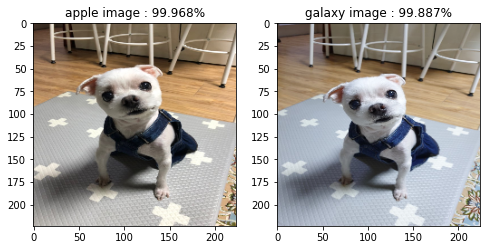

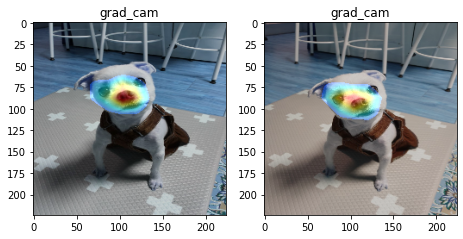

In [19]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.title("apple image : {}%".format(round(float(apple_pred[0][0]*100),3)))
plt.imshow(apple[:,:,:])
plt.subplot(1,2,2)
plt.title("galaxy image : {}%".format(round(float(galaxy_pred[0][0]*100),3)))
plt.imshow(galaxy[:,:,:])

grad_cam(vgg_trained_model, [apple, galaxy])

# 고양이

In [0]:
cat_pred = vgg_trained_model(np.expand_dims(cat,axis=0))

cat_add_1_pred = vgg_trained_model(np.expand_dims(cat_add_1,axis=0))
cat_add_5_pred = vgg_trained_model(np.expand_dims(cat_add_5,axis=0))

cat_add_random_10_pred = vgg_trained_model(np.expand_dims(cat_random_10,axis=0))
cat_add_random_30_pred = vgg_trained_model(np.expand_dims(cat_random_30,axis=0))
cat_add_random_50_pred = vgg_trained_model(np.expand_dims(cat_random_50,axis=0))

cat_add_line_1_pred = vgg_trained_model(np.expand_dims(cat_add_line_1,axis=0))
cat_add_line_2_pred = vgg_trained_model(np.expand_dims(cat_add_line_2,axis=0))
cat_add_line_3_pred = vgg_trained_model(np.expand_dims(cat_add_line_3,axis=0))

cat_add_gauss_pred = vgg_trained_model(np.expand_dims(cat_add_gauss,axis=0))

cat_add_sp_pred = vgg_trained_model(np.expand_dims(cat_add_sp,axis=0))

cat_add_poisson_pred = vgg_trained_model(np.expand_dims(cat_add_poisson,axis=0))

cat_add_speckle_pred = vgg_trained_model(np.expand_dims(cat_add_speckle,axis=0))

## 픽셀값 1, 5 증가 사진 비교

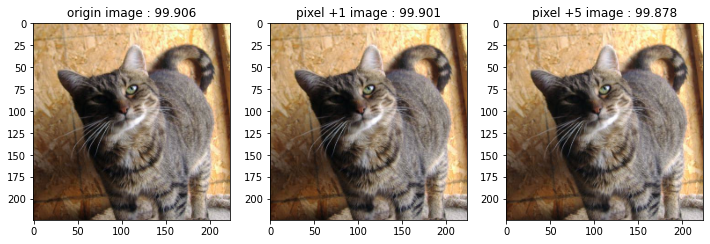

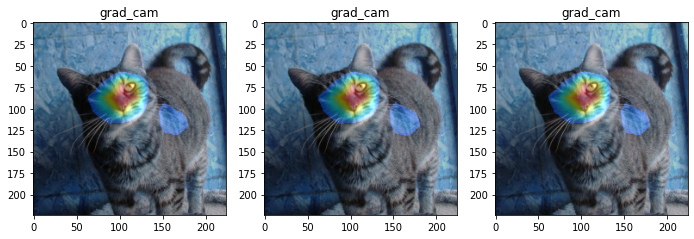

In [21]:
plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
plt.title("origin image : {}".format(round(float((1-cat_pred[0][0])*100),3)))
plt.imshow(cat[:,:,:])

plt.subplot(1,3,2)
plt.title("pixel +1 image : {}".format(round(float((1-cat_add_1_pred[0][0])*100),3)))
plt.imshow(cat_add_1[:,:,:])

plt.subplot(1,3,3)
plt.title("pixel +5 image : {}".format(round(float((1-cat_add_5_pred[0][0])*100),3)))
plt.imshow(cat_add_5[:,:,:])

grad_cam(vgg_trained_model, [cat, cat_add_1, cat_add_5])

## 이미지 랜덤 피셀값 증가, 감소 
* 전체 픽셀 10, 30, 50% 각 픽셀값 -5 ~ +5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


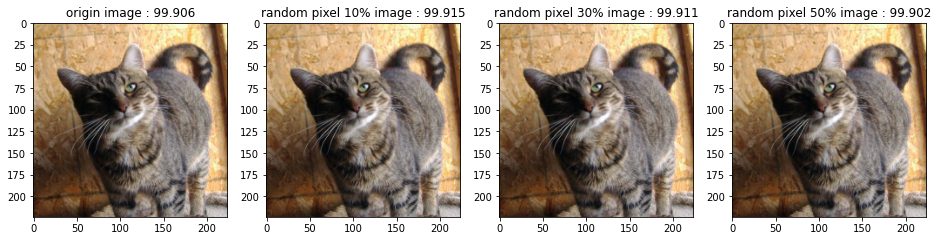

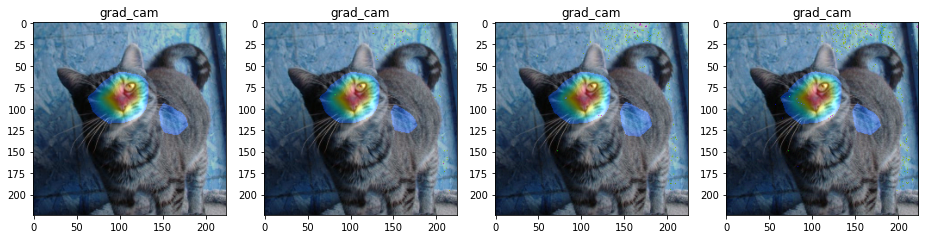

In [22]:
plt.figure(figsize=(16,16))
plt.subplot(1,4,1)
plt.title("origin image : {}".format(round(float((1-cat_pred[0][0])*100),3)))
plt.imshow(cat[:,:,:])

plt.subplot(1,4,2)
plt.title("random pixel 10% image : {}".format(round(float((1-cat_add_random_10_pred[0][0])*100),3)))
plt.imshow(cat_random_10[:,:,:])

plt.subplot(1,4,3)
plt.title("random pixel 30% image : {}".format(round(float((1-cat_add_random_30_pred[0][0])*100),3)))
plt.imshow(cat_random_30[:,:,:])

plt.subplot(1,4,4)
plt.title("random pixel 50% image : {}".format(round(float((1-cat_add_random_50_pred[0][0])*100),3)))
plt.imshow(cat_random_50[:,:,:])

grad_cam(vgg_trained_model, [cat, cat_random_10, cat_random_30, cat_random_50])

## 사선 이미지 합성 사진 비교

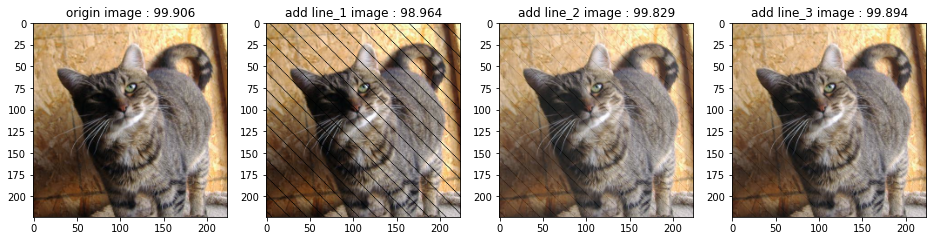

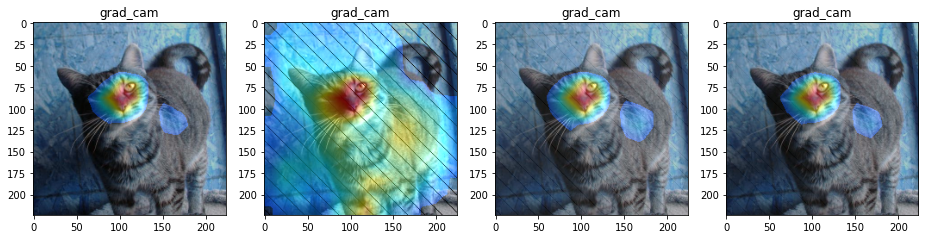

In [23]:
plt.figure(figsize=(16,16))
plt.subplot(1,4,1)
plt.title("origin image : {}".format(round(float((1-cat_pred[0][0])*100),3)))
plt.imshow(cat[:,:,:])

plt.subplot(1,4,2)
plt.title("add line_1 image : {}".format(round(float((1-cat_add_line_1_pred[0][0])*100),3)))
plt.imshow(cat_add_line_1[:,:,:])

plt.subplot(1,4,3)
plt.title("add line_2 image : {}".format(round(float((1-cat_add_line_2_pred[0][0])*100),3)))
plt.imshow(cat_add_line_2[:,:,:])

plt.subplot(1,4,4)
plt.title("add line_3 image : {}".format(round(float((1-cat_add_line_3_pred[0][0])*100),3)))
plt.imshow(cat_add_line_3[:,:,:])

grad_cam(vgg_trained_model, [cat, cat_add_line_1, cat_add_line_2, cat_add_line_3])

## 가우시안 노이즈 사진 비교

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


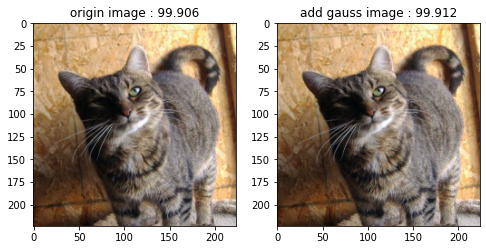

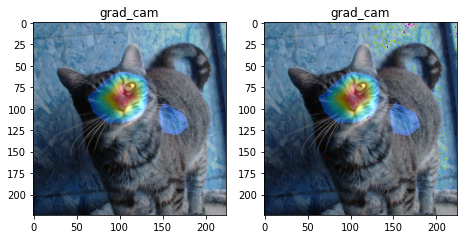

In [24]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.title("origin image : {}".format(round(float((1-cat_pred[0][0])*100),3)))
plt.imshow(cat[:,:,:])

plt.subplot(1,2,2)
plt.title("add gauss image : {}".format(round(float((1-cat_add_gauss_pred[0][0])*100),3)))
plt.imshow(cat_add_gauss[:,:,:])

grad_cam(vgg_trained_model, [cat, cat_add_gauss])

## 소금 후추 노이즈 사진 비교

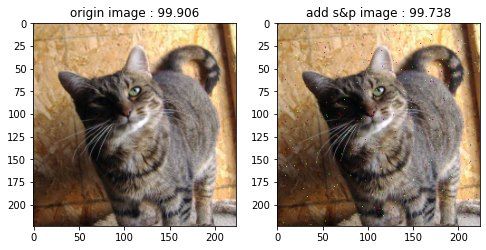

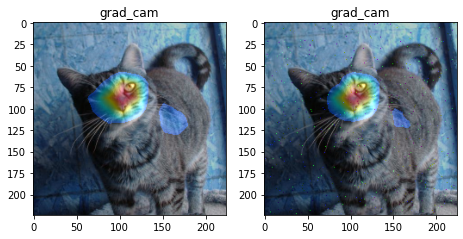

In [25]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.title("origin image : {}".format(round(float((1-cat_pred[0][0])*100),3)))
plt.imshow(cat[:,:,:])

plt.subplot(1,2,2)
plt.title("add s&p image : {}".format(round(float((1-cat_add_sp_pred[0][0])*100),3)))
plt.imshow(cat_add_sp[:,:,:])

grad_cam(vgg_trained_model, [cat, cat_add_sp])

## 푸아송 노이즈 사진 비교

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


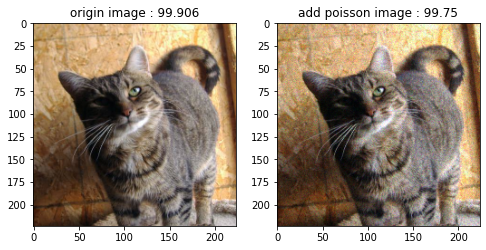

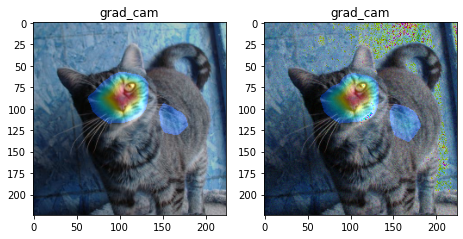

In [26]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.title("origin image : {}".format(round(float((1-cat_pred[0][0])*100),3)))
plt.imshow(cat[:,:,:])

plt.subplot(1,2,2)
plt.title("add poisson image : {}".format(round(float((1-cat_add_poisson_pred[0][0])*100),3)))
plt.imshow(cat_add_poisson[:,:,:])

grad_cam(vgg_trained_model, [cat, cat_add_poisson])

## 스펙클 노이즈 사진 비교

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


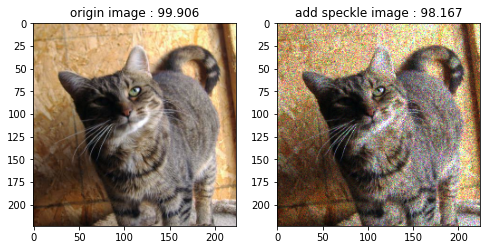

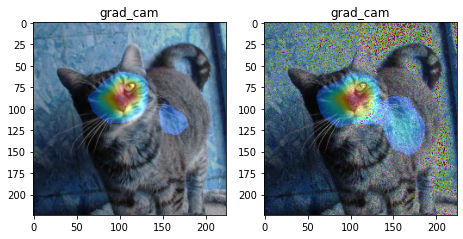

In [27]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.title("origin image : {}".format(round(float((1-cat_pred[0][0])*100),3)))
plt.imshow(cat[:,:,:])

plt.subplot(1,2,2)
plt.title("add speckle image : {}".format(round(float((1-cat_add_speckle_pred[0][0])*100),3)))
plt.imshow(cat_add_speckle[:,:,:])

grad_cam(vgg_trained_model, [cat, cat_add_speckle])

# 다른 이미지 포멧 형식에서의 비교

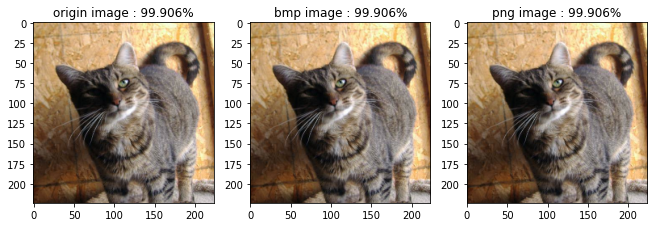

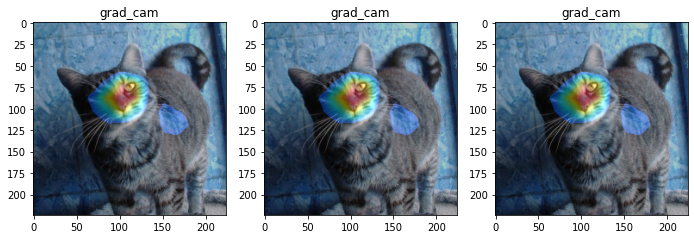

In [28]:
cat_bmp = cv2.imread("/content/gdrive/My Drive/dataset/cat_vs_dog/convert/cat.21.bmp")
cat_bmp = cv2.cvtColor(cat_bmp, cv2.COLOR_BGR2RGB)
cat_bmp = cv2.resize(cat_bmp, (224,224))
cat_bmp = cat_bmp/255.0

cat_png = cv2.imread("/content/gdrive/My Drive/dataset/cat_vs_dog/convert/cat.21.png")
cat_png = cv2.cvtColor(cat_png, cv2.COLOR_BGR2RGB)
cat_png = cv2.resize(cat_png, (224,224))
cat_png = cat_png/255.0

cat_bmp_pred = vgg_trained_model(np.expand_dims(cat_bmp,axis=0))
cat_png_pred = vgg_trained_model(np.expand_dims(cat_png,axis=0))

plt.figure(figsize=(11,11))
plt.subplot(1,3,1)
plt.title("origin image : {}%".format(round(float((1-cat_pred[0][0])*100),3)))
plt.imshow(cat[:,:,:])

plt.subplot(1,3,2)
plt.title("bmp image : {}%".format(round(float((1-cat_bmp_pred[0][0])*100),3)))
plt.imshow(cat_bmp[:,:,:])

plt.subplot(1,3,3)
plt.title("png image : {}%".format(round(float((1-cat_png_pred[0][0])*100),3)))
plt.imshow(cat_png[:,:,:])

grad_cam(vgg_trained_model, [cat, cat_bmp, cat_png])